In [1]:
%pip install torch torchvision
%pip install torchmetrics


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pandas as pd
import os

import random
from PIL import Image, ImageDraw
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torchvision

from torchvision import transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [4]:
train_path = 'MOT16/train'
test_path = 'MOT16/test'
subfolders = sorted(os.listdir(train_path))
test_subfolders = sorted(os.listdir(test_path))


In [5]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained = True)
num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [7]:
columns_name = ['ID_img','ID_object','x1','y1','w','h','Conf_scr','Class','Visibility']

In [8]:
from sqlalchemy.sql.expression import column
data_list = []
test_list = []
for folder in subfolders:
  img_dir = os.path.join(train_path, folder, 'gt/gt.txt')
  if os.path.exists(img_dir):
    df = pd.read_csv(img_dir, sep = ',', header = None, names = columns_name)
    # Format ID_img as subfolder/00000X
    df['ID_img'] = df['ID_img'].apply(lambda x: f"{folder}/{int(x):06d}")
    data_list.append(df)



for folder in test_subfolders:
  test_img_dir = os.path.join(test_path, folder, 'det/det.txt')
  if os.path.exists(test_img_dir):
      test_df = pd.read_csv(test_img_dir, sep=',', header=None, names=columns_name, usecols=list(range(9)))
      # Format ID_img as subfolder/00000X
      test_df['ID_img'] = test_df['ID_img'].apply(lambda x: f"{folder}/{int(x):06d}")
      test_list.append(test_df)

if data_list:
  data = pd.concat(data_list, ignore_index=True)
  test_data = pd.concat(test_list, ignore_index=True)
# else:
#   data = pd.DataFrame(columns=columns_name)
#   test_data = pd.DataFrame(columns=columns_name)

In [9]:
test_data

,ID_img,ID_object,x1,y1,w,h,Conf_scr,Class,Visibility
0,MOT16-01/000001,-1,772.68,455.43,41.871,127.610,2.12620,-1,-1
1,MOT16-01/000001,-1,717.79,451.29,44.948,136.840,1.79690,-1,-1
2,MOT16-01/000001,-1,230.74,465.07,21.974,67.922,1.67180,-1,-1
3,MOT16-01/000001,-1,1001.70,455.86,63.980,193.940,0.63705,-1,-1
4,MOT16-01/000001,-1,702.64,374.21,73.643,222.930,-0.10042,-1,-1
...,...,...,...,...,...,...,...,...,...
135371,MOT16-14/000750,-1,1553.10,486.03,59.629,180.890,-0.40033,-1,-1
135372,MOT16-14/000750,-1,1517.80,375.27,97.492,294.470,-0.40202,-1,-1
135373,MOT16-14/000750,-1,364.89,442.87,63.980,193.940,-0.40261,-1,-1
135374,MOT16-14/000750,-1,1793.00,489.00,39.000,119.000,-0.43301,-1,-1


In [10]:
data

,ID_img,ID_object,x1,y1,w,h,Conf_scr,Class,Visibility
0,MOT16-02/000001,1,912,484,97,109,0,7,1.00000
1,MOT16-02/000002,1,912,484,97,109,0,7,1.00000
2,MOT16-02/000003,1,912,484,97,109,0,7,1.00000
3,MOT16-02/000004,1,912,484,97,109,0,7,1.00000
4,MOT16-02/000005,1,912,484,97,109,0,7,1.00000
...,...,...,...,...,...,...,...,...,...
199962,MOT16-13/000176,177,268,534,13,90,0,10,1.00000
199963,MOT16-13/000177,177,263,534,13,90,0,10,1.00000
199964,MOT16-13/000292,178,1523,471,26,177,0,10,0.00000
199965,MOT16-13/000293,178,1539,482,26,176,0,10,0.51852


In [11]:
data['x2'] = data['x1'] + data['w']
data['y2'] = data['y1'] + data['h']

test_data['x2'] = test_data['x1'] + test_data['w']
test_data['y2'] = test_data['y1'] + test_data['h']


In [12]:
data.drop(['ID_object','Conf_scr','Visibility','w','h'], axis = 1 , inplace = True)
data = data[['ID_img', 'x1', 'y1', 'x2', 'y2', 'Class']]


test_data.drop(['ID_object','Conf_scr','Visibility','w','h'], axis = 1 , inplace = True)
test_data = test_data[['ID_img', 'x1', 'y1', 'x2', 'y2', 'Class']]

In [13]:
data = data[data['Class'] == 1] #Only detect pedestrian

In [14]:
test_data['Class'] = 1
test_data

,ID_img,x1,y1,x2,y2,Class
0,MOT16-01/000001,772.68,455.43,814.551,583.040,1
1,MOT16-01/000001,717.79,451.29,762.738,588.130,1
2,MOT16-01/000001,230.74,465.07,252.714,532.992,1
3,MOT16-01/000001,1001.70,455.86,1065.680,649.800,1
4,MOT16-01/000001,702.64,374.21,776.283,597.140,1
...,...,...,...,...,...,...
135371,MOT16-14/000750,1553.10,486.03,1612.729,666.920,1
135372,MOT16-14/000750,1517.80,375.27,1615.292,669.740,1
135373,MOT16-14/000750,364.89,442.87,428.870,636.810,1
135374,MOT16-14/000750,1793.00,489.00,1832.000,608.000,1


In [15]:
unique_imgs = data['ID_img'].unique()

In [16]:
class CustDat(torch.utils.data.Dataset):
  def __init__(self, data, unique_imgs, indices,is_train = True):
    self.data = data
    self.unique_imgs = unique_imgs
    self.indices = indices
    self.train_path = train_path
    self.test_path = test_path
    self.subfolders = subfolders
    self.is_train = is_train

  def __len__(self):
    return len(self.indices)
  def __getitem__(self,idx):
    Image_ID = self.unique_imgs[self.indices[idx]]
    boxes = self.data[self.data['ID_img'] == Image_ID].values[:, 1:5].astype('float')

    # Split Image_ID into folder and filename (e.g. MOT16-02 and 000001)
    folder, filename = Image_ID.split('/')
    # Construct path with img1 directory
    if self.is_train:
      img_path = os.path.join(self.train_path, folder, 'img1', filename + '.jpg')
    else:
      img_path = os.path.join(self.test_path, folder, 'img1', filename + '.jpg')
    img = Image.open(img_path).convert('RGB')
    labels = self.data[self.data['ID_img'] == Image_ID].values[:,5].astype('float')

    target = {}
    target['boxes'] = torch.tensor(boxes)
    target['labels'] = torch.tensor(labels)
    return T.ToTensor()(img), target

In [17]:
train_idx , val_idx = train_test_split(range(unique_imgs.shape[0]), test_size = 0.1)
test_idx = list(range(len(test_data['ID_img'].unique())))

In [18]:
def custom_collage(data):
  return data

In [26]:
train_dl = torch.utils.data.DataLoader(
    CustDat(data,unique_imgs,train_idx, is_train = True),
    batch_size = 25, # Increased from 4 to 16 to utilize more GPU RAM
    shuffle = True,
    collate_fn = custom_collage,
    num_workers = 0, # Enable parallel data loading to speed up training
    pin_memory = True if torch.cuda.is_available() else False
)
val_dl = torch.utils.data.DataLoader(
    CustDat(test_data,test_data['ID_img'].unique(),test_idx,is_train = False),
    batch_size = 8, # Increased from 4 to 16
    shuffle = True,
    collate_fn = custom_collage,
    num_workers = 0, # Enable parallel data loading
    pin_memory = True if torch.cuda.is_available() else False
)

In [20]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

In [21]:
optimizer = torch.optim.SGD(model.parameters(), lr = 0.005, momentum = 0.5, weight_decay= 0.0005)


In [27]:
# --- Code to LOAD checkpoint and RESUME training ---
# Run this cell when you want to continue training in a new session

load_path = 'MOT16-model/faster_rcnn_mot16_checkpoint.pth'
model.to(device)
if os.path.exists(load_path):
    # Load checkpoint with weights_only=False to allow numpy types
    checkpoint = torch.load(load_path, map_location=device, weights_only=False)

    # Restore model and optimizer state
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    # Restore last epoch
    total_epoch = checkpoint['epoch']
    print(f"Checkpoint loaded successfully. Resuming from epoch {total_epoch}")
else:
    print("No checkpoint found. Starting from scratch.")
    total_epoch = 0

Checkpoint loaded successfully. Resuming from epoch 70


In [23]:
# # --- TRAINING LOOP ---
# num_epochs = 5
# model.train()
# model.to(device)# Move model to GPU
# for epochs in range(num_epochs):
#   epoch_loss = 0
#   for data_batch in train_dl:
#     imgs = []
#     targets = []
#     for d in data_batch:
#       imgs.append(d[0].to(device))
#       targ = {}
#       targ['boxes'] = d[1]['boxes'].to(device)
#       # Cast labels to int64
#       targ['labels'] = d[1]['labels'].to(device, dtype=torch.int64)
#       targets.append(targ)
#     loss_dict = model(imgs, targets)
#     loss = sum(v for v in loss_dict.values())
#     epoch_loss += loss.cpu().detach().numpy()
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
#   print(f"Epoch {epochs+1} Loss: {epoch_loss}")

# total_epoch += num_epochs

In [29]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision
import torch

# 1. Re-define Validation DataLoader using the Training Split (val_idx)
# is_train=True because the images are in the train folder
val_dl_proper = torch.utils.data.DataLoader(
    CustDat(data, unique_imgs, val_idx, is_train=True),
    batch_size=8,
    shuffle=False,
    collate_fn=custom_collage,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

# 2. Evaluation Function
def evaluate_map(model, loader, device):
    model.eval()
    metric = MeanAveragePrecision(iou_type="bbox")

    print(f"Starting evaluation on {len(loader)} batches...")
    with torch.no_grad():
        for batch_idx, data_batch in enumerate(loader):
            images = []
            targets = []
            for d in data_batch:
                images.append(d[0].to(device))
                targ = {}
                targ["boxes"] = d[1]["boxes"].to(device)
                targ["labels"] = d[1]["labels"].to(device, dtype=torch.int64)
                targets.append(targ)

            preds = model(images)
            metric.update(preds, targets)

            if (batch_idx + 1) % 20 == 0:
                print(f"Processed {batch_idx + 1}/{len(loader)} batches...")

    results = metric.compute()
    return results

# 3. Run Evaluation
print("Calculating mAP on Validation set...")
metrics = evaluate_map(model, val_dl_proper, device)

print("\n=== Validation Results ===")
print(f"mAP: {metrics['map']:.4f}")
print(f"mAP@50: {metrics['map_50']:.4f}")
print(f"mAP@75: {metrics['map_75']:.4f}")



Calculating mAP on Validation set...
Starting evaluation on 67 batches...
Processed 20/67 batches...
Processed 40/67 batches...
Processed 60/67 batches...

=== Validation Results ===
mAP: 0.6641
mAP@50: 0.8859
mAP@75: 0.7563


Detected objects (Score > 0.5):
 - Pedestrian: 1.0000
 - Pedestrian: 1.0000
 - Pedestrian: 0.9999
 - Pedestrian: 0.9984
 - Pedestrian: 0.9976
 - Pedestrian: 0.9950
 - Pedestrian: 0.9558
 - Pedestrian: 0.9557
 - Pedestrian: 0.8945


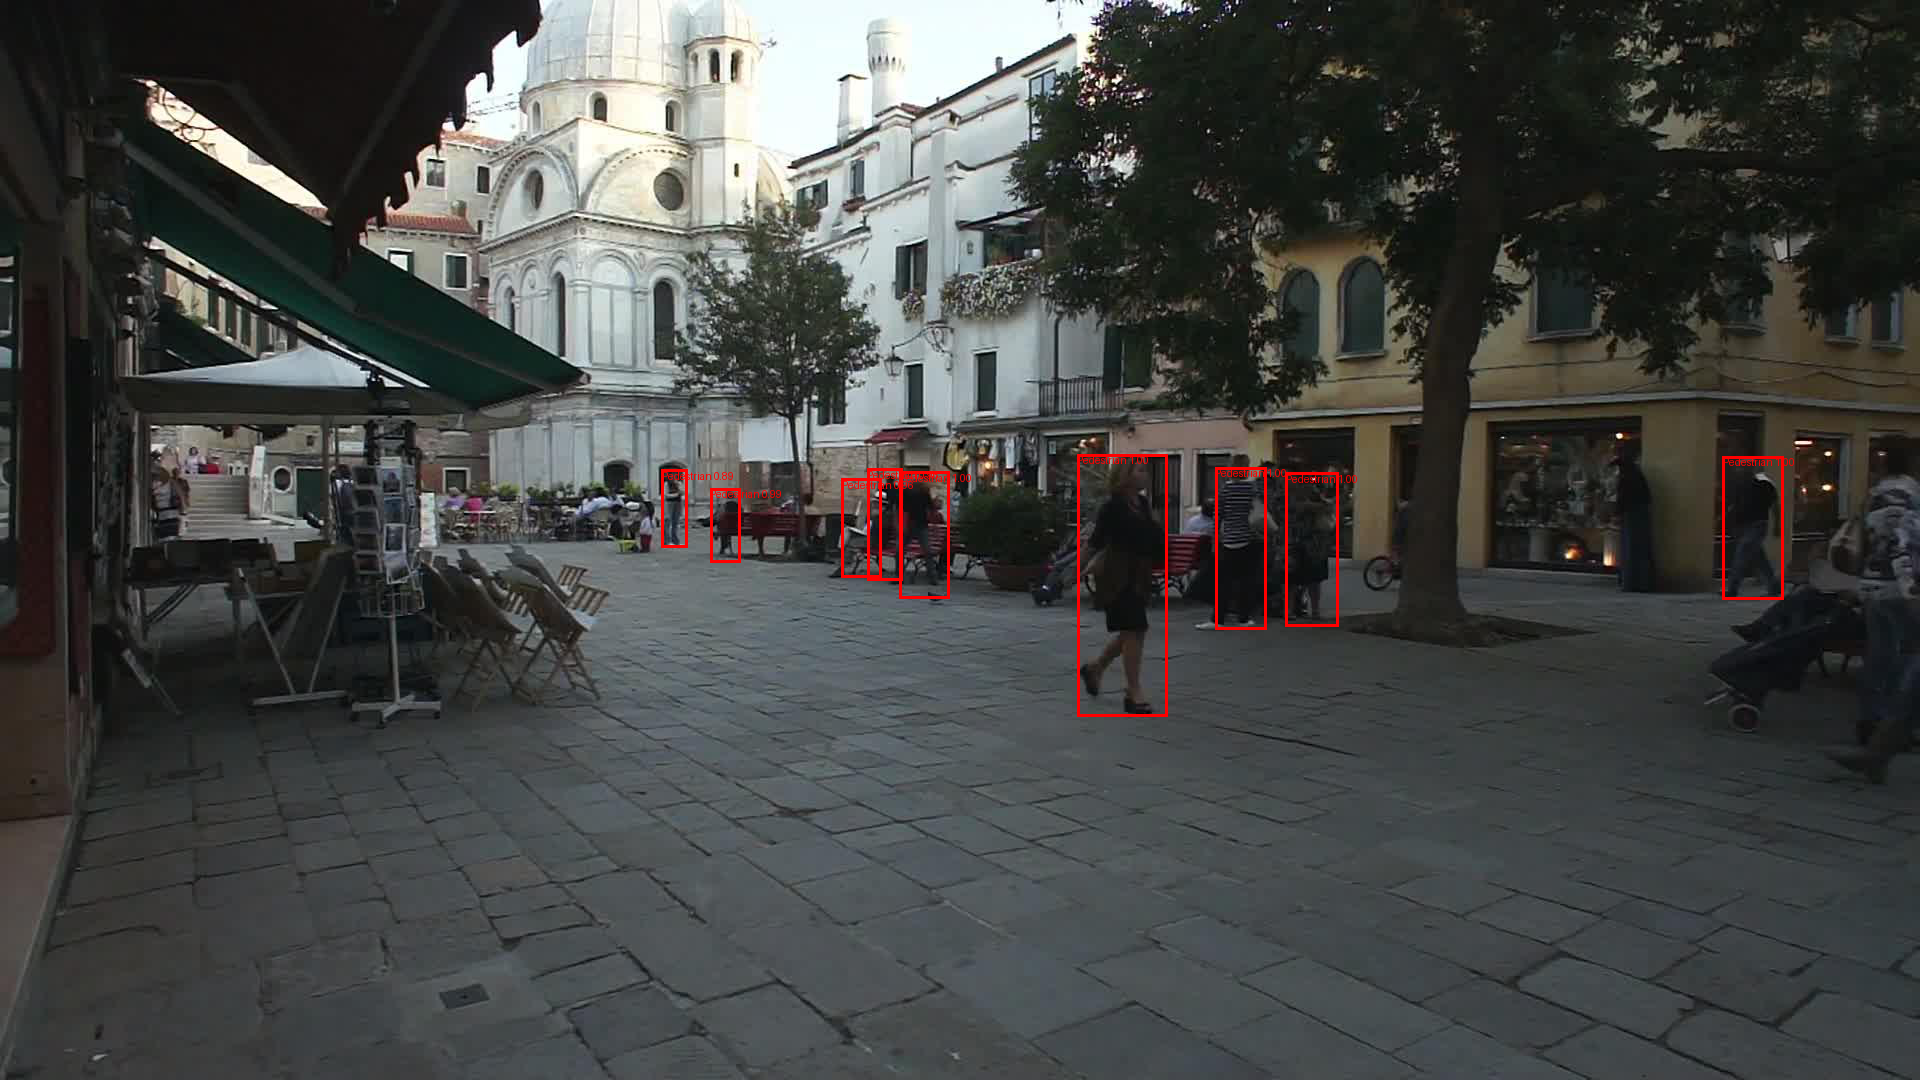

In [32]:
from PIL import Image, ImageDraw, ImageFont
import torchvision
import torch


# Initialize iterator from the fixed dataloader
val_iter = iter(val_dl)
dt = next(val_iter)

# Get the first image in the batch
img_tensor = dt[0][0]


model.eval()
with torch.no_grad():
    output = model([img_tensor.to(device)])


out_bbox = output[0]['boxes']
out_scores = output[0]['scores']
out_labels = output[0]['labels']

keep = torchvision.ops.nms(out_bbox, out_scores, 0.3)

im_np = (img_tensor.permute(1, 2, 0).cpu().numpy() * 255).astype('uint8')
vsample = Image.fromarray(im_np)
draw = ImageDraw.Draw(vsample)

# Load Font
try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf", 30)
except IOError:
    font = ImageFont.load_default()

print(f"Detected objects (Score > 0.5):")
found = False
for i in keep:
    score = out_scores[i].item()
    if score < 0.5: continue # Threshold

    found = True
    box = out_bbox[i].cpu().numpy()
    label = out_labels[i].item()
    name = 'Pedestrian'

    # Draw box and text
    draw.rectangle(list(box), outline='red', width=3)
    draw.text((box[0], box[1]), f"{name} {score:.2f}", fill='red', font=font)
    print(f" - {name}: {score:.4f}")

if not found:
    print("No objects detected.")

display(vsample)

In [ ]:
### CREATE VIDEO

# import cv2
# import os
# import torch
# import shutil
# from torchvision.transforms import functional as F

# images_folder = '/content/drive/MyDrive/Colab Notebooks/MOT16/test/MOT16-02/img1'
# video_name = 'detection_test_01.mp4'
# fps = 24

# images = sorted([img for img in os.listdir(images_folder) if img.endswith(".jpg")])

# frame = cv2.imread(os.path.join(images_folder, images[0]))
# height, width, layers = frame.shape

# fourcc = cv2.VideoWriter_fourcc(*'mp4v')
# video = cv2.VideoWriter(video_name, fourcc, fps, (width, height))

# model.eval()
# model.to(device)
# with torch.no_grad():
#   for images_name in images:
#     img_path = os.path.join(images_folder, images_name)
#     orig_image = cv2.imread(img_path)

#     img_tensor = F.to_tensor(orig_image).unsqueeze(0).to(device)
#     predictions = model(img_tensor)
#     for box, score,label in zip(predictions[0]['boxes'], predictions[0]['scores'], predictions[0]['labels']):
#       if score > 0.5:
#         x1, y1, x2, y2 = box.cpu().numpy().astype(int)
#         cv2.rectangle(orig_image, (x1, y1), (x2, y2), (0,255,0),2)
#         cv2.putText(orig_image,f'{label}',(x1,y1), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0),2)
#     video.write(orig_image)

# video.release()

# # Save to Drive for persistence
# drive_path = os.path.join('/content/drive/MyDrive/Colab Notebooks/MOT16/video', video_name)
# shutil.copy(video_name, drive_path)
# print(f"Video copied to Google Drive: {drive_path}")

Video copied to Google Drive: /content/drive/MyDrive/Colab Notebooks/MOT16/video/detection_test_01.mp4


In [ ]:
# # Save the model state and optimizer state to Drive
# save_path = '/content/drive/MyDrive/Colab Notebooks/MOT16-model/faster_rcnn_mot16_checkpoint.pth'

# # Create the directory if it doesn't exist
# os.makedirs(os.path.dirname(save_path), exist_ok=True)

# torch.save({
#     'epoch': total_epoch,
#     'model_state_dict': model.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict(),
#     'loss': epoch_loss,
#     }, save_path)

# print(f"Model checkpoint saved to {save_path}")

Model checkpoint saved to /content/drive/MyDrive/Colab Notebooks/MOT16-model/faster_rcnn_mot16_checkpoint.pth
